In [135]:
import numpy as np
import GEOparse as gp
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
from IPython.display import display
import sklearn
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from scipy.cluster.hierarchy import dendrogram, linkage

We download the data from the GSE dataset

In [118]:
gse = gp.get_GEO(geo="GSE157239", destdir="./")

02-Dec-2020 00:41:28 DEBUG utils - Directory ./ already exists. Skipping.
02-Dec-2020 00:41:28 INFO GEOparse - File already exist: using local version.
02-Dec-2020 00:41:28 INFO GEOparse - Parsing ./GSE157239_family.soft.gz: 
02-Dec-2020 00:41:28 DEBUG GEOparse - DATABASE: GeoMiame
02-Dec-2020 00:41:28 DEBUG GEOparse - SERIES: GSE157239
02-Dec-2020 00:41:28 DEBUG GEOparse - PLATFORM: GPL21572
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/GEOparse/GEOparse.py:110: DtypeWarning: Columns (7) have mixed types.Specify dtype option on import or set low_memory=False.
  return parse_GSE(filepath, open_kwargs=open_kwargs)
02-Dec-2020 00:41:35 DEBUG GEOparse - SAMPLE: GSM4759790
02-Dec-2020 00:41:35 DEBUG GEOparse - SAMPLE: GSM4759791
02-Dec-2020 00:41:35 DEBUG GEOparse - SAMPLE: GSM4759792
02-Dec-2020 00:41:35 DEBUG GEOparse - SAMPLE: GSM4759793
02-Dec-2020 00:41:35 DEBUG GEOparse - SAMPLE: GSM4759794
02-Dec-2020 00:41:35 DEBUG GEOparse - SAMPLE: GSM4759795
02-De

In [ ]:
# Significance level
alpha = 0.01

# Identifying which samples are controls
control_columns = np.array([0, 1, 2, 4, 6, 9, 11, 15])
c = np.zeros(16, dtype=bool)
c[control_columns] = 1

# Creating accessible matrices from the dataset
values = []
for k, v in gse.gsms.items():
    ids = v.table["ID_REF"].to_numpy()
    values.append(v.table['VALUE'].to_numpy())
values = np.stack(values, axis=-1)

mask = np.broadcast_to(c, (len(values), 16))

controls = values[mask].reshape(-1, 8)
samples = values[~mask].reshape(-1, 8)

# Running one-way ANOVA analysis on the RNAs
f_stats = stats.f_oneway(controls, samples, axis=-1)
num_significant = np.sum(f_stats.pvalue < alpha)
signif_ids = ids[f_stats.pvalue < alpha]

# Sorting by p-value
ids = np.array(ids)
order = np.argsort(f_stats.pvalue)
sorted_ids = ids[order]

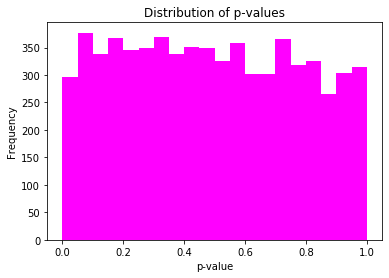

In [166]:
raw_data = gse.gpls['GPL21572'].table

signifs = []
for sig_id in signif_ids:
    signifs.append(raw_data[raw_data["ID"] == sig_id])
signifs = pd.concat(signifs)
signifs.insert(16, "P-value", f_stats.pvalue[f_stats.pvalue < alpha])

#np.nonzero(raw_data["ID"] == sig_id for sig_id in signif_ids)

sorted_pvalues = np.copy(f_stats.pvalue)
sorted_pvalues.sort()

signif_indices = []
for i in np.arange(len(f_stats.pvalue)):
    if f_stats.pvalue[i] < alpha:
        signif_indices.append(i)

# Plotting distribution of p-values
plt.hist(sorted_pvalues, bins = 20, color = 'magenta')
plt.title('Distribution of p-values')
plt.xlabel('p-value')
plt.ylabel('Frequency')

mirna_mask = signifs['Sequence Type'] == 'miRNA'
mirna_signifs = signifs[mirna_mask]

To determine if each gene is upregulated or downregulated, we compare the mean values against the control.

In [121]:
regulations = np.mean(samples, axis=-1) > np.mean(controls, axis=-1)

# True if upregulated, False if downregulated
signif_regulations = regulations[f_stats.pvalue < alpha]

labeled_sig_regs = np.stack([
    signifs['Transcript ID(Array Design)'].to_numpy(), signif_regulations], axis=-1)

In [122]:
# Creating table of p-values, regulation patterns, and functions of each miRNA of interest
data = {'P-value': signifs[mirna_mask]['P-value'].values, 
        'Regulation (case vs. control)':['Upregulated', 'Downregulated', 'Upregulated', 'Downregulated', 'Downregulated', 'Upregulated', 'Downregulated', 'Downregulated', 'Downregulated', 'Upregulated', 
                                         'Upregulated', 'Upregulated', 'Upregulated', 'Upregulated', 'Upregulated', 'Downregulated', 'Downregulated', 'Downregulated', 'Downregulated', 'Downregulated'], 
        'Function':['Tumor suppression', 'Cell proliferation', 'Tumor suppression', 'DNA methylation', 'Regulates A\u03B2', 'Cell proliferation', 'Cell proliferation', 'Cell proliferation',
                   'Tumor suppression', 'Tumor suppression', 'Lipid metabolism', 'N/A', 'N/A', 'N/A', 'Tumor suppression', 'N/A', 'N/A', 'N/A', 'N/A', 'Regulate autoimmune disease']} 

df = pd.DataFrame(data, index =['miR-215-3p', 'miR-369-5p', 'miR-429', 'miR-767-5p', 'miR-1251-5p', 'miR-1470', 'miR-3180-5p', 'miR-4286', 'miR-500b-3p', 'miR-3912-5p', 'miR-3929', 'miR-4540', 'miR-4633-3p',
                               'miR-4653-5p', 'miR-203b-5p', 'miR-4791', 'miR-5003-3p', 'miR-5093', 'miR-6877-5p', 'miR-7155-3p']) 

display(df)


,P-value,Regulation (case vs. control),Function
miR-215-3p,0.008630,Upregulated,Tumor suppression
miR-369-5p,0.003104,Downregulated,Cell proliferation
miR-429,0.007773,Upregulated,Tumor suppression
miR-767-5p,0.006993,Downregulated,DNA methylation
miR-1251-5p,0.009721,Downregulated,Regulates Aβ
miR-1470,0.009135,Upregulated,Cell proliferation
miR-3180-5p,0.002045,Downregulated,Cell proliferation
miR-4286,0.000047,Downregulated,Cell proliferation
miR-500b-3p,0.001586,Downregulated,Tumor suppression
miR-3912-5p,0.002591,Upregulated,Tumor suppression


In [123]:
# Normalizing data for clustering
values_norm = values

for i in np.arange(len(values[:, 0])):
    mean = np.mean(values[i, ])
    stdev = np.std(values[i, ])
    for j in np.arange(len(values[0, ])):
        values_norm[i][j] = (values[i][j] - mean) / stdev

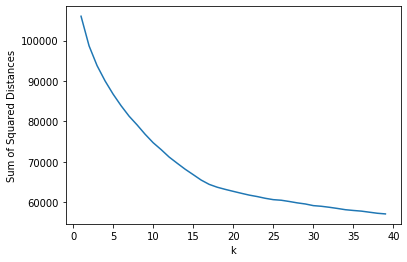

In [124]:
# K-means clustering
sum_of_squared_distances = []
for k in range(1, 40):
    kmeans = KMeans(n_clusters = k).fit(values_norm)
    sum_of_squared_distances.append(kmeans.inertia_)
    
plt.plot(range(1, 40), sum_of_squared_distances)
plt.xlabel('k')
plt.ylabel('Sum of Squared Distances')
plt.show()


In [153]:
kmeans = KMeans(n_clusters = 16).fit(values_norm)

#argmin, distance = sklearn.metrics.pairwise_distances_argmin_min(kmeans.cluster_centers_, values_norm)
#print(ids[argmin])

signif_labels_list = kmeans.labels_[signif_indices]
mirna_signif_labels_list = signif_labels_list[0:20]

print(mirna_signif_labels_list)

[ 6  2  1  7  2  1  4 12  7  6  1  1  1  1  6 13  2 13 12 13]


In [133]:
# PCA
pca = PCA(n_components = 16)
pca.fit(values_norm)
print(pca.explained_variance_ratio_)

[1.02201494e-01 9.00496840e-02 7.94746101e-02 7.66516575e-02
 6.96785569e-02 6.82502061e-02 6.66784690e-02 6.33104588e-02
 6.14032054e-02 5.99681263e-02 5.61813070e-02 5.47881095e-02
 5.27793642e-02 4.95327608e-02 4.90519902e-02 9.22413862e-31]


RecursionError: maximum recursion depth exceeded while getting the str of an object

<Figure size 1800x720 with 0 Axes>